# 1. Environment Setup

This model is trained on my local machine which is running: 
- Nvidia GeForce RTX 2070 8GB GDDR6 
- Intel Core i7-6700k OC @ 4.5GHz

Software used:
- VSCode with Jupyter extension
- Python running in a virtual environment

In [ ]:
###### Packages ######
# !pip install -U virtualenv
# !pip install -U IPython
# !pip install -U jupyter
# !pip install -U tensorflow
# !pip install -U keras-tuner
# !pip install -U pandas
# !pip install -U matplotlib
# !pip install -U seaborn
# !pip install -U scipy

In [1]:
import os
os.environ['PYTHONHASHSEED'] = '0'
import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers

import kerastuner as kt
from kerastuner import HyperModel, RandomSearch, BayesianOptimization, Hyperband

physical_devices_CPU = tf.config.list_physical_devices('CPU') 
physical_devices_GPU = tf.config.list_physical_devices('GPU') 
# This is to fix GPU performance issues for my local environment. TensorFlow runtime initialization will not allocate all memory on the device. 
tf.config.experimental.set_memory_growth(physical_devices_GPU[0], True)

print('Running TensorFlow', tf.__version__)
print('Running KerasTuner', kt.__version__)
print('CPUs Available:', len(physical_devices_CPU))
print('GPUs Available:', len(physical_devices_GPU))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns

# Set random seeds to constants for better reproducibility
import random as rn
seed = 6
rn.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

# Plot styles
%matplotlib inline
plt.rcParams['figure.figsize'] = (15,5)
plt.rcParams["font.family"] = 'DejaVu Sans'
plt.rcParams["font.size"] = '12'
plt.rcParams['image.cmap'] = 'rainbow'

Running TensorFlow2.2.0
Running KerasTuner1.0.1
CPUs Available:1
GPUs Available:1


# 2. Understanding the Data

Import dataset and preview. There are 1030 entries with 9 columns. Descriptions of the variables:

- Cement (kg/m<sup>3</sup>)
- Fly ash (kg/m<sup>3</sup>)
- Blast furnace slag (kg/m<sup>3</sup>)
- Water (kg/m<sup>3</sup>)
- Superplasticiser (kg/m<sup>3</sup>)
- Coarse aggregate (kg/m<sup>3</sup>)
- Fine aggregate (kg/m<sup>3</sup>)
- Age of testing (days)
- Concrete compressive strength (MPa)

In [2]:
dataset = pd.read_csv('Concrete_Data.csv')
print(dataset.head(), '\n')
print('Shape of data set:', dataset.shape)

cement   slag  flyash  water  superplas  coarse_agg  fine_agg  age  \
0   540.0    0.0     0.0  162.0        2.5      1040.0     676.0   28   
1   540.0    0.0     0.0  162.0        2.5      1055.0     676.0   28   
2   332.5  142.5     0.0  228.0        0.0       932.0     594.0  270   
3   332.5  142.5     0.0  228.0        0.0       932.0     594.0  365   
4   198.6  132.4     0.0  192.0        0.0       978.4     825.5  360   

   strength  
0     79.99  
1     61.89  
2     40.27  
3     41.05  
4     44.30

Shape of data set:(1030, 9)


## 2.1 Distribution

Plot distributions of dataset to understand the nature of the data.
- The ingredients are plotted against compressive strength.
- Many distributions are skewed and not Gaussian.
- Many distributions contain many 0 values which are important to preserve for the model as it represents if ingredients are present or not.
    - Try to make the network learn the effect of missing some ingredients on strength.

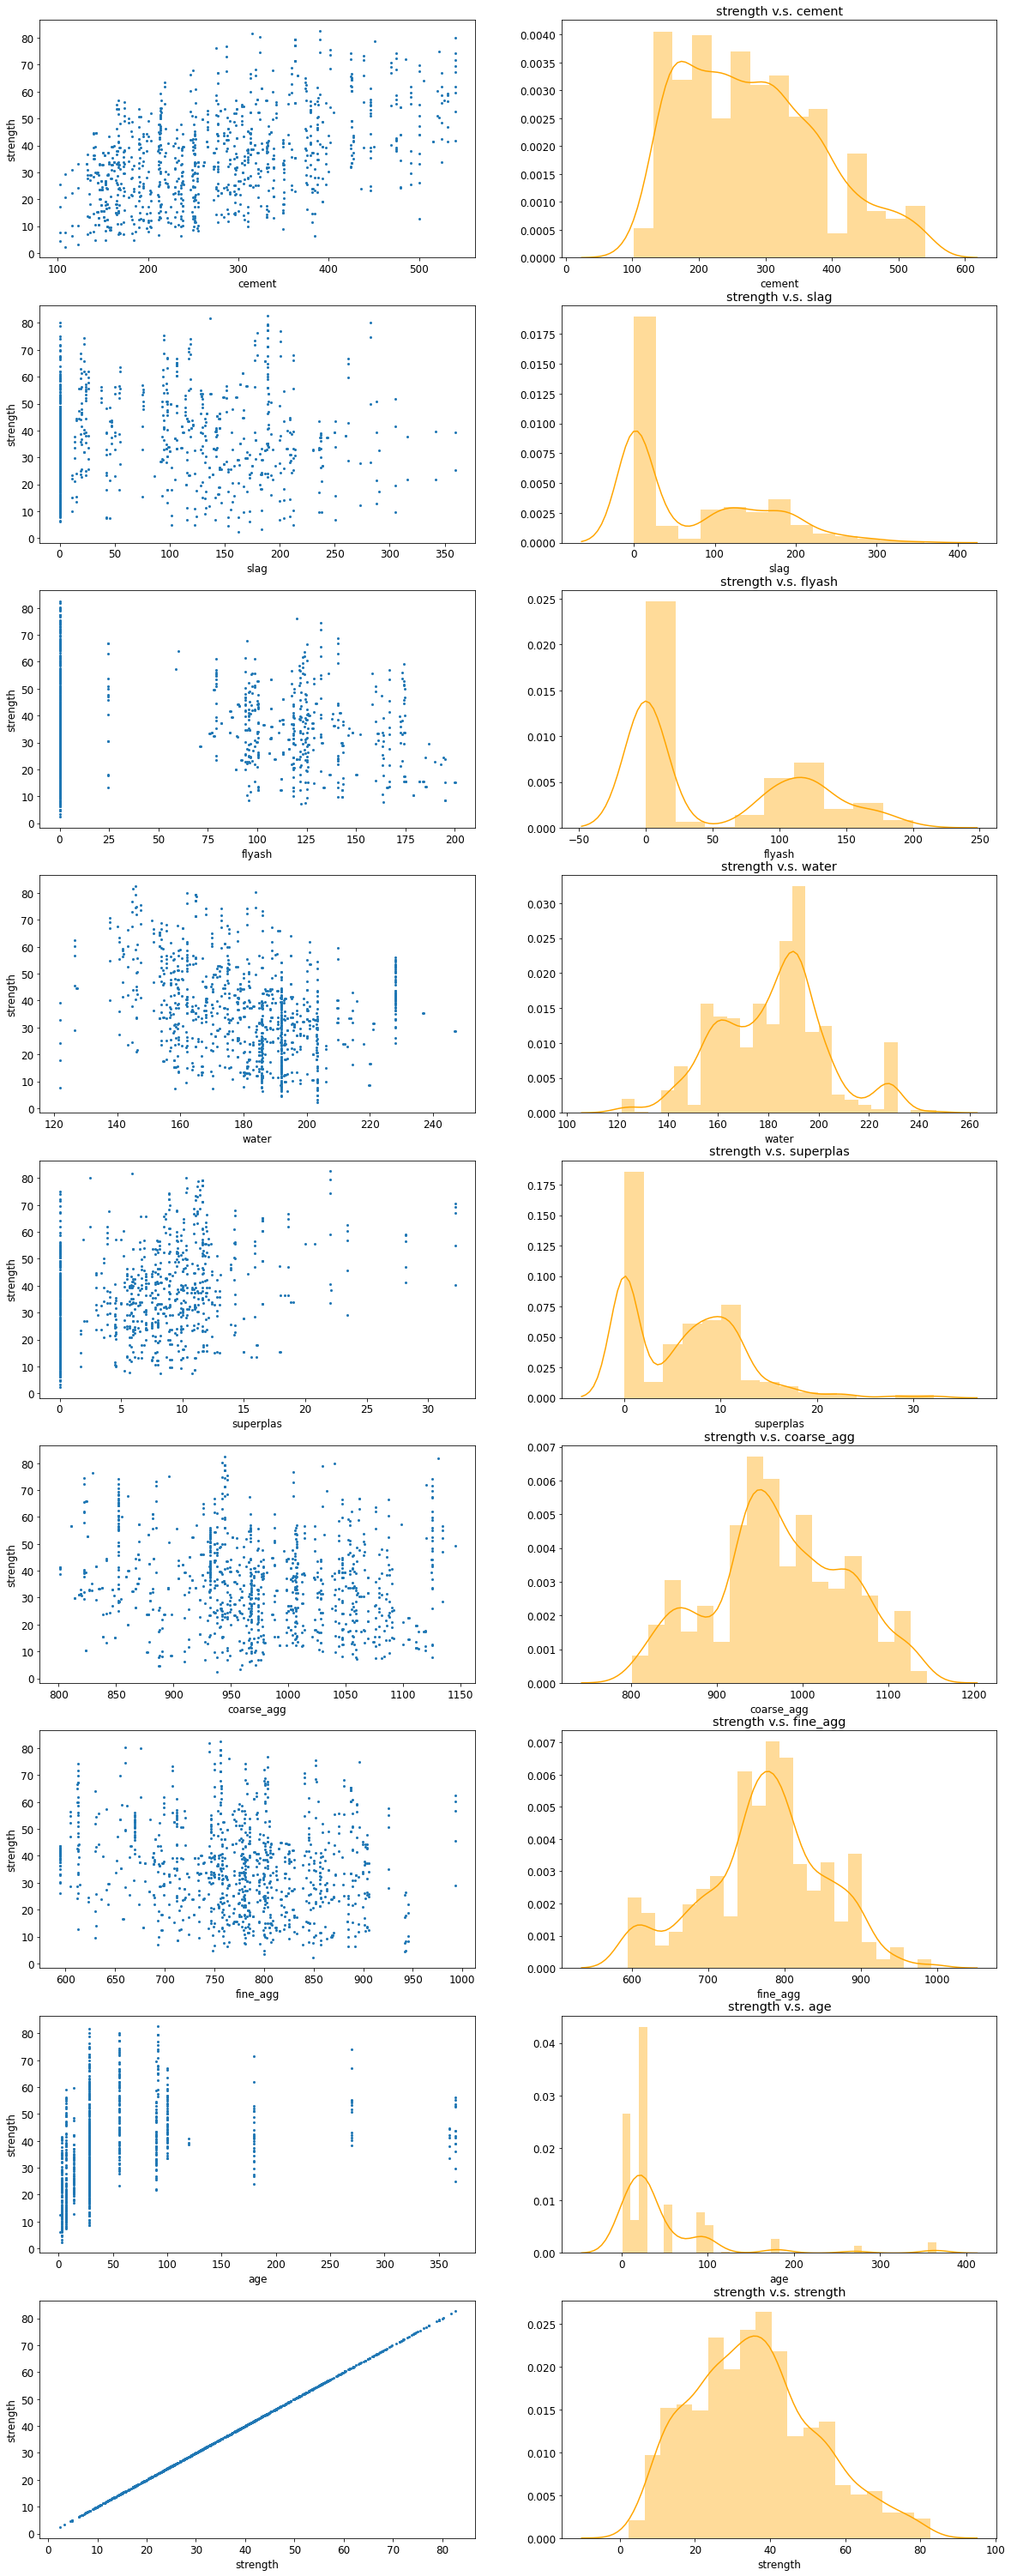

In [3]:
# Get names of columns (keys) 
keys = [f for f in dataset.columns]

# Plot figure and axes for each key
fig, ax = plt.subplots(len(keys),2,figsize=(20,len(keys)*6))

# Plotting loop for all variables
for n in range(len(keys)):
    feat = keys[n]
    title = 'strength v.s. ' + f'{feat}'
    ax[n,0].scatter(dataset[feat].values, dataset.strength.values, s=4)
    ax[n,0].set_ylabel('strength')
    ax[n,0].set_xlabel(feat)
    sns.distplot(dataset[feat].dropna(), kde=True, ax=ax[n,1], color='orange')
    ax[n,1].set_title(title)

## 2.2 Correlation

- Amount of cement has moderate positive effect on strength.
- Amount of fly ash has moderate negative effect on strength.
- All other variables seem to have slight negative or no correlation to strength.

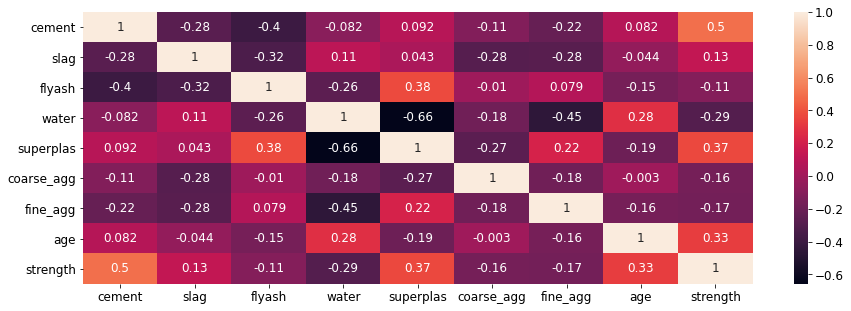

In [4]:
sns.heatmap(dataset.corr(), annot = True)

## 2.3 Normality
Check if dataset is normal:

In [5]:
test_normality = lambda x: stats.shapiro(x.fillna(0))[1] < 0.01
normal = pd.DataFrame(dataset)
normal = normal.apply(test_normality)
print('Is dataset normal?', not normal.any())

Is dataset normal?False


## 2.4 Splitting the dataset
Split dataset for training/testing in 80/20.

In [6]:
train_dataset = dataset.sample(frac=0.8,random_state=69) # Take 80% of dataset for training.
test_dataset = dataset.drop(train_dataset.index) # Take the rest for testing.
print('Training dataset shape:', train_dataset.shape)
print('Testing dataset shape:', test_dataset.shape)

Training dataset shape:(824, 9)
Testing dataset shape:(206, 9)


Get dataset min, max, mean and standard deviation as values needed for scaling the data.

In [7]:
train_stats = train_dataset.describe() # Get dataset min, max, mean, standard deviation etc.
train_stats.pop('strength') # Remove strength column as it is not needed.
train_stats = train_stats.transpose() # Transpose and show stats for dataset.
train_stats

,count,mean,std,min,25%,50%,75%,max
cement,824.0,281.377306,104.495567,102.0,194.4,269.40,351.250,540.0
slag,824.0,73.903277,86.092338,0.0,0.0,22.00,142.500,359.4
flyash,824.0,53.997937,63.164905,0.0,0.0,0.00,118.300,195.0
water,824.0,181.990413,21.217147,121.8,164.9,185.70,192.000,247.0
superplas,824.0,6.206311,6.001590,0.0,0.0,6.35,10.325,32.2
coarse_agg,824.0,972.764320,78.171931,801.0,932.0,968.00,1030.000,1145.0
fine_agg,824.0,773.141262,80.462484,594.0,724.3,780.10,824.250,992.6
age,824.0,44.993932,62.216931,1.0,7.0,28.00,56.000,365.0


In [8]:
train_labels = train_dataset.pop('strength') # Separate strength from dataset to train network.
test_labels = test_dataset.pop('strength') # Separate strength from dataset to test after training.

print('Training labels have shape:', train_labels.shape)
print('Testing labels have shape:', test_labels.shape)

Training labels have shape:(824,)
Testing labels have shape:(206,)


## 2.5 Standardise Data

Data is can be normalised or standardised to improve model performance. 
- Normalisation remaps values to fit between 0 and 1.
- Standardisation remaps values to so that the mean of observed values is 0 and the standard deviation is 1. Standardisation assumes that the data fits a Gaussian distribution (bell curve) with a well behaved mean and standard deviation. However, data can still be standardised if this condition is not met, but may yield unreliable results.

In this case, standardisation is chosen after comparing performance of the models.

cement      slag    flyash     water  superplas  coarse_agg  fine_agg  \
42  -0.419896  1.900247 -0.854872  2.168510  -1.034111   -0.521470 -2.226395   
184 -0.564400 -0.858419  0.676041  0.344513  -0.284310   -0.072460  1.207504   
131  0.939013  0.897835 -0.854872 -1.323949   1.615187    2.066415 -2.089685   
550  1.068205 -0.858419 -0.854872  0.471769  -1.034111   -0.411456  0.154839   
808 -0.281134 -0.858419 -0.854872  0.188979  -1.034111    1.768354  0.134954   

          age  
42   5.143392  
184 -0.674960  
131 -0.273140  
550 -0.610669  
808 -0.610669


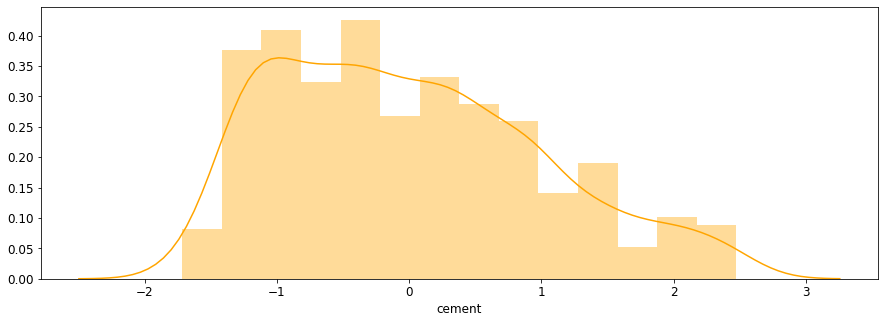

In [9]:
# Define function to normalise/standardise dataset.
# Replace the function below with this one for normalistion:
  # return (x - train_stats['min']) / (train_stats['max'] - train_stats['min'])

def standardise(x):
  return (x - train_stats['mean']) / train_stats['std'] # Standardise

# Standardise training and test dataset
normed_train_data = standardise(train_dataset)
normed_test_data = standardise(test_dataset)

# Check the dataset after standardisation:
print(normed_train_data.head())
sns.distplot(normed_train_data['cement'], kde=True, color='orange')

# 3. Create Model

Create sequential artificial neural network with 8 inputs, 3 hidden layers and 1 output.

- Dropout layers are set between dense layers to reduce overfitting.
- L2 Regularisers are used with λ = 0.01 to further reduce overfitting.
- The model is trained for metrics in MAE (mean absolute error) and MSE (mean squared error).
- Batch size is set to 32. (Although I have read 'batch size' = 'sample size' will give more accurate results, 32 is performing better in this model)
- Validation set is 20% of the training set.
- Early stop is called when validation loss stops improving after 20 epochs.

In [10]:
# Define training function with structure, activation, optimizer and epochs
def train_network(structure, activation, optimizer, epochs):
    model = keras.models.Sequential()

# See above for model details
    model.add(keras.layers.Dense(units = structure[1], input_dim = structure[0], activation = activation, kernel_regularizer=regularizers.l2(0.01))) 
    layers.Dropout(0.5)
    model.add(keras.layers.Dense(units = structure[2], activation = activation, kernel_regularizer=regularizers.l2(0.01)))
    layers.Dropout(0.5)
    model.add(keras.layers.Dense(units = structure[3], activation = activation, kernel_regularizer=regularizers.l2(0.01)))
    layers.Dropout(0.5)
    model.add(keras.layers.Dense(units = structure[-1], activation = None)) # activation = none is the same as linear activation

# Compile model
    model.compile(loss = 'mse', optimizer = optimizer, metrics = ['mae', 'mse', 'mape'])

# Print summary of network that is being trained
    print(model.summary(), '\n')
    
    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20) # Stop training early when validation loss does not improve after 20 epochs 
# Train model by calling model.fit()     
    training_stats = model.fit(normed_train_data, train_labels, batch_size = 32, epochs = epochs, validation_split = 0.2, verbose = 0, callbacks=[early_stop])

    return training_stats, model

## 3.1 Training Loop
Trial and error for different number of hidden neurons to optimise for MSE and MAE.

===== Evaluating model with 128 hidden neurons===== 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #
dense (Dense)                (None, 128)               1152
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129
Total params: 34,305
Trainable params: 34,305
Non-trainable params: 0
_________________________________________________________________
None

          loss       mae       mse      mape   val_loss   val_mae    val_mse  \
177  13.373352  2.190597  9.005904  7.651152  30.509686  3.489348  26.140320   
178  12.584131  2.093723  8.212904  7.215019  32.966209 

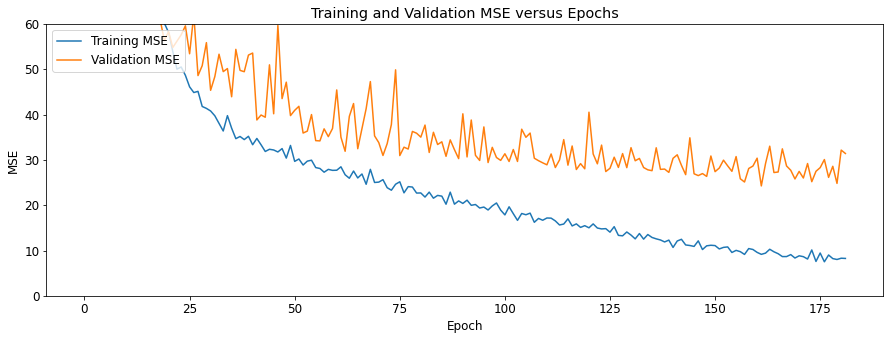

===== Evaluating model with 160 hidden neurons===== 

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #
dense_4 (Dense)              (None, 160)               1440
_________________________________________________________________
dense_5 (Dense)              (None, 160)               25760
_________________________________________________________________
dense_6 (Dense)              (None, 160)               25760
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 161
Total params: 53,121
Trainable params: 53,121
Non-trainable params: 0
_________________________________________________________________
None

         loss       mae        mse       mape   val_loss   val_mae    val_mse  \
78  25.708656  3.537158  21.457993  11.720052  39.901257  4.416513  35.645611   
79  24.805548  3.510859  20.541790  11.726376  38.14

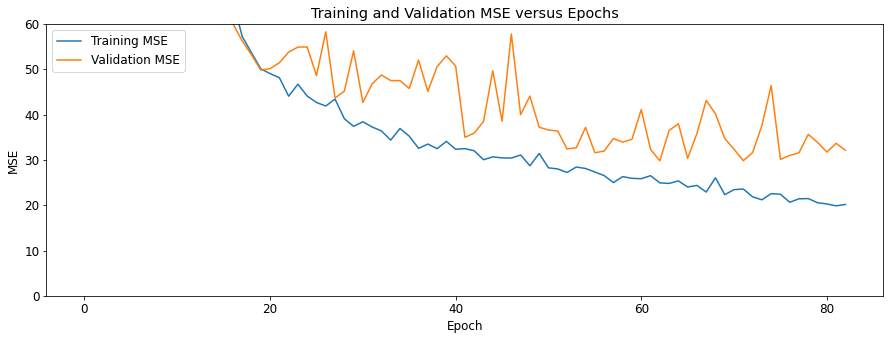

===== Evaluating model with 192 hidden neurons===== 

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #
dense_8 (Dense)              (None, 192)               1728
_________________________________________________________________
dense_9 (Dense)              (None, 192)               37056
_________________________________________________________________
dense_10 (Dense)             (None, 192)               37056
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 193
Total params: 76,033
Trainable params: 76,033
Non-trainable params: 0
_________________________________________________________________
None

         loss       mae        mse       mape   val_loss   val_mae    val_mse  \
87  22.857693  3.188687  17.736366  10.966360  39.062267  4.203443  33.941246   
88  20.860077  2.995080  15.724821   9.906359  34.61

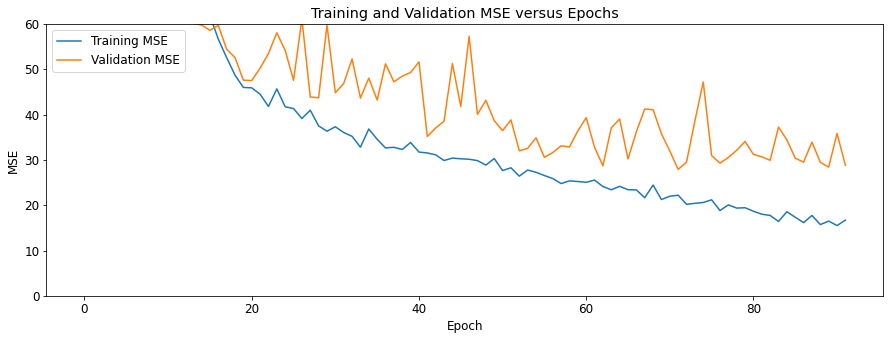

===== Evaluating model with 224 hidden neurons===== 

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #
dense_12 (Dense)             (None, 224)               2016
_________________________________________________________________
dense_13 (Dense)             (None, 224)               50400
_________________________________________________________________
dense_14 (Dense)             (None, 224)               50400
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 225
Total params: 103,041
Trainable params: 103,041
Non-trainable params: 0
_________________________________________________________________
None

          loss       mae        mse      mape   val_loss   val_mae    val_mse  \
107  16.395592  2.406271  10.398543  8.314012  36.879284  3.994279  30.878578   
108  17.386324  2.459254  11.385189  8.488247  35.

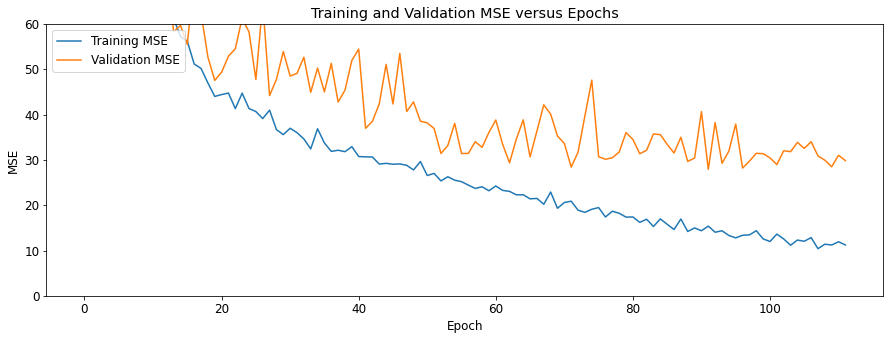

===== Evaluating model with 256 hidden neurons===== 

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #
dense_16 (Dense)             (None, 256)               2304
_________________________________________________________________
dense_17 (Dense)             (None, 256)               65792
_________________________________________________________________
dense_18 (Dense)             (None, 256)               65792
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 257
Total params: 134,145
Trainable params: 134,145
Non-trainable params: 0
_________________________________________________________________
None

          loss       mae        mse      mape   val_loss   val_mae    val_mse  \
112  17.241993  2.435344  10.772021  8.543671  33.685802  3.684572  27.220558   
113  16.539953  2.314526  10.074852  7.723737  35.

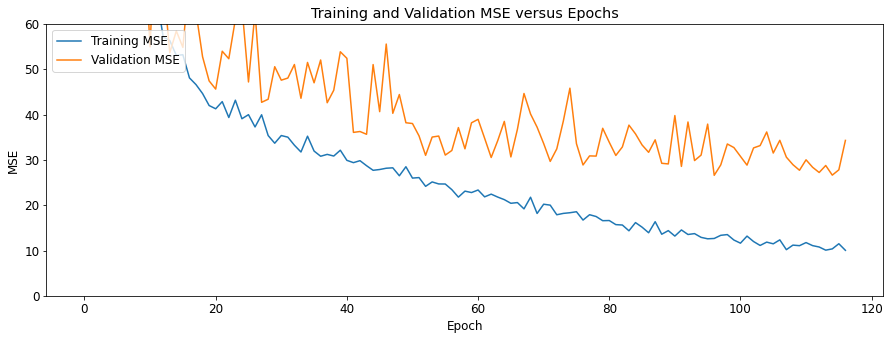

In [11]:
# Loop over 128 to 256 hidden neurons in multiples of 32 for 3 hidden layers.
for hidden1 in range (128, 257, 32):
    print('===== Evaluating model with %i hidden neurons' %hidden1, ' ===== \n')
    training_stats, model = train_network(structure = [8, hidden1, hidden1, hidden1, 1], activation = 'tanh', optimizer = 'RMSprop', epochs = 512)
    hist = pd.DataFrame(training_stats.history) # Get training history data
    hist['epoch'] = training_stats.epoch # Append epochs to end of history data for easier interpretation
    print(hist.tail(), '\n') # Print training data

# Plot MSE which is the main metric we are using to evaluate the model training accuracy
    plt.plot(training_stats.history['mse'])
    plt.plot(training_stats.history['val_mse'])
    plt.title('Training and Validation MSE versus Epochs')
    plt.ylim([0,60])
    plt.ylabel('MSE')
    plt.xlabel('Epoch')
    plt.legend(['Training MSE', 'Validation MSE'], loc='upper left')
    plt.show()

## 3.2 Evaluate Model
The model is evaluated against test dataset to see how it performs with unseen data

In [12]:
loss, mae, mse, mape = model.evaluate(normed_test_data, test_labels, verbose=0) # Evaulate model against test data and labels
print('Test set MSE (Mean Squared Error): {:5.2f}'.format(mse)) # Print MSE
print('Test set MAE (Mean Absolute Error): {:5.2f} MPa'.format(mae), ' ({:5.2f}%)'.format(mape) ) # Print MAE and MAPE

Test set MSE (Mean Squared Error): 32.42
Test set MAE (Mean Absolute Error):  4.17 MPa (13.75%)


### 3.3 Plotting Model Predictions 
Plot predictions on test data against the true values of strength from test set. As seen from the graph, the model predicts reasonably well.

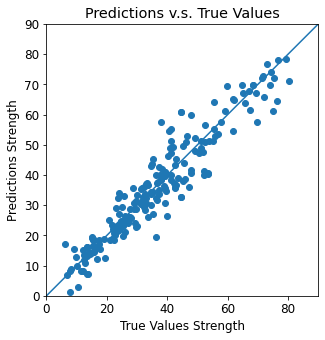

In [13]:
test_predictions = model.predict(normed_test_data).flatten() # Call model.predict() to see predictions
# Plot predictions against true values
a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values Strength')
plt.ylabel('Predictions Strength')
plt.title('Predictions v.s. True Values')
lims = [0, 90]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

Also visualise the error distribution between the predictions and true values of strength.

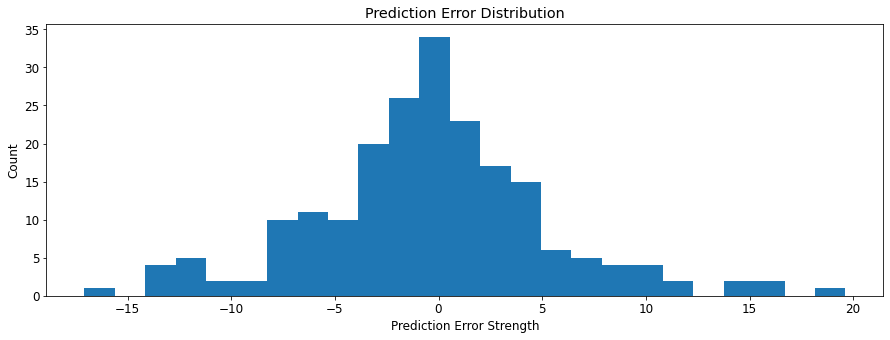

In [14]:
# Plot histogram
error = test_predictions - test_labels # error is calculated by subtracting prediction values from true values
plt.hist(error, bins = 25)
plt.title('Prediction Error Distribution')
plt.xlabel('Prediction Error Strength')
_ = plt.ylabel('Count')

# 4. Automating Hyperparameter Tuning with Keras Tuner

Hyperparameter tuning can be automated with Keras Tuner which provides tools to trial and error more efficiently. A hypermodel is defined by subclassing the the `HyperModel` class of the Keras Tuner API (more details here)[https://keras-team.github.io/keras-tuner/#you-can-use-a-hypermodel-subclass-instead-of-a-model-building-function]. 

Search spaces for the number of hidden neurons and activation function are defined for Keras Tuner to loop over. Since this is a regression model, `relu`, `tanh` and `sigmoid` are selected as possible activation functions.

Keras Tuner provides various inbuilt tuners available: `BayesianOptimization`, `Hyperband`, `RandomSearch`, and `Sklearn`


In [15]:
# Define hypermodel as subclass of the HyperModel class in Keras Tuner API
class RegressionHyperModel(HyperModel):
    def __init__(self, input_shape):
        self.input_shape = input_shape    
        
    def build(self, hp):
        model = keras.models.Sequential()
        # Add hidden layers, input layers and corresponding search spaces
        model.add(
            keras.layers.Dense(
                input_shape=input_shape,
                units=hp.Int('units', 128, 257, 16, default=128), 
                activation=hp.Choice(
                    'dense_activation',
                    values=['relu', 'tanh', 'sigmoid'],
                    default='relu'),
                kernel_regularizer=regularizers.l2(0.01),
            )
        )
        # Add dropout layers
        model.add(
            layers.Dropout(0.4)
        ) 
        model.add(
            keras.layers.Dense(
                units=hp.Int('units', 128, 257, 16, default=128),
                activation=hp.Choice(
                    'dense_activation',
                    values=['relu', 'tanh', 'sigmoid'],
                    default='relu'),
                kernel_regularizer=regularizers.l2(0.01),
            )
        )
        model.add(
            layers.Dropout(0.4)
        ) 
        # Add output layer and compile model.
        model.add(layers.Dense(1))
        model.compile(
            optimizer='RMSprop', loss='mse', metrics=['mae','mse']
        )
        return model

## 4.1 Bayesian Optimisation

Instantiate tuner and perform hypertuning with Bayesian optimisation. Bayesian optimisation uses probability to find the best model by keeping track of past evaluations.

In [16]:
# Define input dimensions
input_shape = (normed_train_data.shape[1],)
# Create instance of HyperModel class
hypermodel = RegressionHyperModel(input_shape)
# Call early stop if validation loss does not improve after 20 epochs
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

# Instantiate tuner
tuner_bo = BayesianOptimization(
            hypermodel,
            objective = 'mse', # Set Keras Tuner to optimise for MSE metric.
            seed = 42, # Setting a seed for reproducbility.
            max_trials = 16, # How many variations (permutations) on model?
            executions_per_trial = 2, # How many trials per variation? (same model could perform differently in separate runs)
            project_name = 'concrete', # Save tuning models for later in this directory './concrete/kerastuner/bayesianOptimisation'
            directory = 'kerastuner/bayesianOptimisation')

# Perform hypertuning
tuner_bo.search(normed_train_data, train_labels, batch_size = 32, epochs = 512, validation_split = 0.2, verbose = 0, callbacks=[early_stop])
from IPython.display import clear_output
clear_output() # Clear the super long log
# tuner_bo.results_summary() # Uncomment this line to recieve full logs

# Return the best model, its hyperparameters and network summary.
best_model_bo = tuner_bo.get_best_models()[0]
print('\n ======== The best hyperparameters were:', tuner_bo.get_best_hyperparameters()[0].values, '======== \n')
print('\n ======== Summary of best model ======== \n')
tuner_bo.get_best_models()[0].summary()

# Return loss, MSE and MAE for the best model
print('\n ======== MSE MAE ======== \n')
loss, mae, mse = best_model_bo.evaluate(normed_test_data, test_labels, verbose=0)
print('Test set MSE (Mean Squared Error): {:5.2f}'.format(mse)) # Print MSE
print('Test set MAE (Mean Absolute Error): {:5.2f} MPa'.format(mae)) # Print MAE and MAPE


 ======== The best hyperparameters were:{'units': 256, 'dense_activation': 'tanh'}======== 


 ======== Summary of best model ======== 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #
dense (Dense)                (None, 256)               2304
_________________________________________________________________
dropout (Dropout)            (None, 256)               0
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257
Total params: 68,353
Trainable params: 68,353
Non-trainable params: 0
_________________________________________________________________

 ======== MSE MAE 

## 4.2 Random Search

Instantiate tuner and perform hypertuning with random searching. Random searching will randomly try hyperparameters in the search space and return the best one.

In [17]:
# Properties in this are the same as for Bayesian optimisation above:
tuner_rs = RandomSearch(
            hypermodel,
            objective = 'mse',
            seed = 42,
            max_trials = 16,
            executions_per_trial=2,
            project_name = 'concrete',
            directory='kerastuner/randomSearch')

# Perform hypertuning
tuner_rs.search(normed_train_data, train_labels, batch_size = 32, epochs = 512, validation_split = 0.2, verbose = 0, callbacks=[early_stop])
from IPython.display import clear_output
clear_output() # Clear the super long log
# tuner_bo.results_summary() # Uncomment this line to recieve full logs

# Return the best model, its hyperparameters and network summary.
best_model_rs = tuner_rs.get_best_models()[0]
print('\n ======== The best hyperparameters were:', tuner_rs.get_best_hyperparameters()[0].values, '======== \n')
print('\n ======== Summary of best model ======== \n')
tuner_rs.get_best_models()[0].summary()

# Return loss, MSE and MAE for the best model
loss, mae, mse = best_model_rs.evaluate(normed_test_data, test_labels, verbose=0)
print('Test set MSE (Mean Squared Error): {:5.2f}'.format(mse)) # Print MSE
print('Test set MAE (Mean Absolute Error): {:5.2f} MPa'.format(mae)) # Print MAE


 ======== The best hyperparameters were:{'units': 240, 'dense_activation': 'tanh'}======== 


 ======== Summary of best model ======== 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #
dense (Dense)                (None, 240)               2160
_________________________________________________________________
dropout (Dropout)            (None, 240)               0
_________________________________________________________________
dense_1 (Dense)              (None, 240)               57840
_________________________________________________________________
dropout_1 (Dropout)          (None, 240)               0
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 241
Total params: 60,241
Trainable params: 60,241
Non-trainable params: 0
_________________________________________________________________
Test set MSE (Mean 

## 4.3 Hyperband

Instantiate tuner and perform hypertuning with Hyperband. Hyperband is based on the algorithm by (Li et. al)[http://jmlr.org/papers/v18/16-558.html]. Roughly speaking, it is an optimised version of random search.

In [18]:
# Properties in this are the same as for Bayesian optimisation above excapt for max_epochs:
tuner_hb = Hyperband(
            hypermodel,
            objective='mse',
            max_epochs=192, # For Keras Tuner Docs: 'The maximum number of epochs to train one model. It is recommended to set this to a value slightly higher than the expected time to convergence for your largest Model'
            seed=42,
            executions_per_trial=2,
            project_name = 'concrete',
            directory='kerastuner/hyperBand')

# Perform hypertuning
tuner_hb.search(normed_train_data, train_labels, batch_size = 32, epochs = 512, validation_split = 0.2, verbose = 0, callbacks=[early_stop])
from IPython.display import clear_output
clear_output() # Clear the super long log
# tuner_bo.results_summary() # Uncomment this line to recieve full logs

# Return the best model, its hyperparameters and network summary.
best_model_hb = tuner_hb.get_best_models()[0]
print('\n ======== The best hyperparameters were:', tuner_hb.get_best_hyperparameters()[0].values, '======== \n')
print('\n ======== Summary of best model ======== \n')
tuner_hb.get_best_models()[0].summary()

# Return loss, MSE and MAE for the best model
loss, mae, mse = best_model_hb.evaluate(normed_test_data, test_labels, verbose=0)
print('Test set MSE (Mean Squared Error): {:5.2f}'.format(mse)) # Print MSE
print('Test set MAE (Mean Absolute Error): {:5.2f} MPa'.format(mae)) # Print MAE


 ======== The best hyperparameters were:{'units': 256, 'dense_activation': 'relu', 'tuner/epochs': 3, 'tuner/initial_epoch': 0, 'tuner/bracket': 4, 'tuner/round': 0}======== 


 ======== Summary of best model ======== 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #
dense (Dense)                (None, 256)               2304
_________________________________________________________________
dropout (Dropout)            (None, 256)               0
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257
Total params: 68,353
Trainable params: 68,353
Non-trainable params: 0
__

# 5. Results

Putting it all together, the optimal model for this project has:
- 8 input layers, 1 output layer
- 3 hidden layers with 256 neurons each.
- `tanh` as the activation function.
- Dropout layers (0.4) are set between dense layers to reduce overfitting.
- Use L2 regularisers with λ = 0.01 to further reduce overfitting.
- Batch size is set to 32. (Although I have read 'batch size' = 'sample size' will give more accurate results, 32 is performing better in this model)
- Validation set is 20% of the training set.

## 5.1 Overfitting

- The model is trained for metrics in MAE (mean absolute error) and MSE (mean squared error).
- Early stop is called when validation loss stops improving after 20 epochs.
- As seen from the plots below, both validation begins to level of which is an indication that overfitting is beginning to start.
- The model is called to stop training before hard overfitting

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #
dense_3 (Dense)              (None, 256)               2304
_________________________________________________________________
dense_4 (Dense)              (None, 256)               65792
_________________________________________________________________
dense_5 (Dense)              (None, 256)               65792
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 257
Total params: 134,145
Trainable params: 134,145
Non-trainable params: 0
_________________________________________________________________
None

          loss       mae        mse      mape   val_loss   val_mae    val_mse  \
112  17.495560  2.450985  11.019902  8.582899  35.386230  3.836474  28.915323   
113  16.896528  2.381409  10.423636  8.050168  34.289299  3.774991  27.818144   
114  17.185219  2.44814

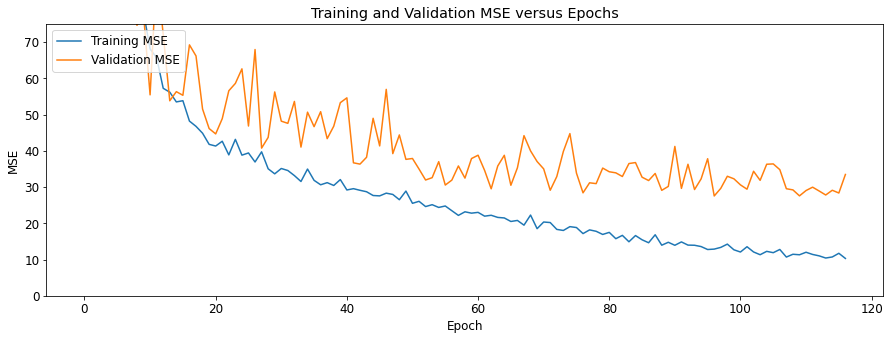

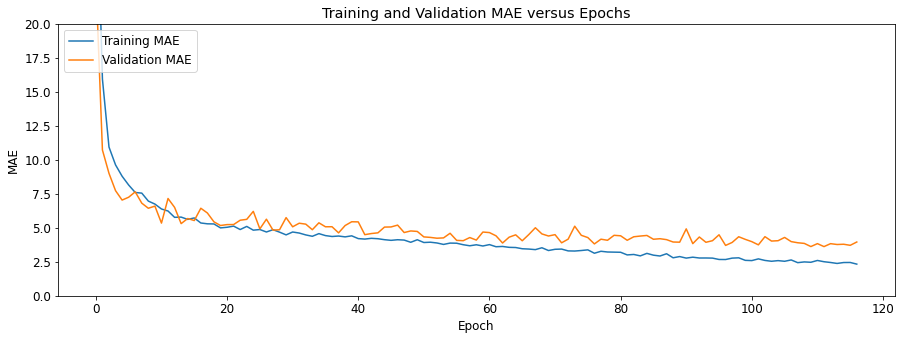

In [19]:
# Define training function with structure, activation, optimizer and epochs
model = keras.models.Sequential()

# See above for model details
model.add(keras.layers.Dense(units = 256, input_dim = 8, activation = 'tanh', kernel_regularizer=regularizers.l2(0.01))) 
layers.Dropout(0.4)
model.add(keras.layers.Dense(units = 256, activation = 'tanh', kernel_regularizer=regularizers.l2(0.01)))
layers.Dropout(0.4)
model.add(keras.layers.Dense(units = 256, activation = 'tanh', kernel_regularizer=regularizers.l2(0.01)))
layers.Dropout(0.4)
model.add(keras.layers.Dense(units = 1, activation = None)) # activation = none is the same as linear activation

# Compile model
model.compile(loss = 'mse', optimizer = 'RMSprop', metrics = ['mae', 'mse', 'mape'])

# Print summary of network that is being trained
print(model.summary(), '\n')

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20) # define early stop
training_stats = model.fit(normed_train_data, train_labels, batch_size = 32, epochs = 512, validation_split = 0.2, verbose = 0, callbacks=[early_stop])

hist = pd.DataFrame(training_stats.history)
hist['epoch'] = training_stats.epoch
print(hist.tail(), '\n')

# Plot MSE
plt.plot(training_stats.history['mse'])
plt.plot(training_stats.history['val_mse'])
plt.title('Training and Validation MSE versus Epochs')
plt.ylim([0,75])
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['Training MSE', 'Validation MSE'], loc='upper left')
plt.show()
# Plot MAE
plt.plot(training_stats.history['mae'])
plt.plot(training_stats.history['val_mae'])
plt.title('Training and Validation MAE versus Epochs')
plt.ylim([0,20])
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Training MAE', 'Validation MAE'], loc='upper left')
plt.show()

## 5.2 Evaluate Final Model
The final model has an MAE of between 3.8 - 4.2 MAE depending on some training variability.

In [20]:
loss, mae, mse, mape = model.evaluate(normed_test_data, test_labels, verbose=0) # Evaulate model against test data and labels
print('Test set MSE (Mean Squared Error): {:5.2f}'.format(mse)) # Print MSE
print('Test set MAE (Mean Absolute Error): {:5.2f} MPa'.format(mae), ' ({:5.2f}%)'.format(mape) ) # Print MAE and MAPE

Test set MSE (Mean Squared Error): 31.84
Test set MAE (Mean Absolute Error):  4.16 MPa (14.03%)


## 5.3 Visualise Prediction Accuracy 

Prediction accuracy is visualised through the same method as in the training loop.

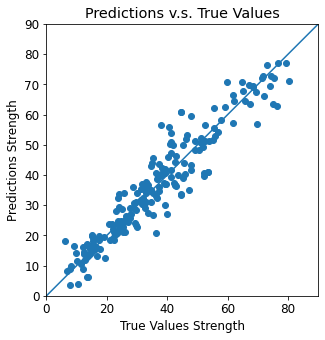

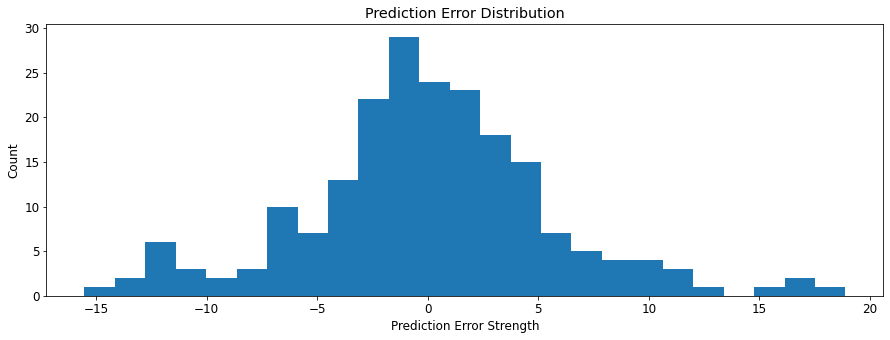

In [21]:
test_predictions = model.predict(normed_test_data).flatten() # Call model.predict() to see predictions
# Plot predictions against true values
a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values Strength')
plt.ylabel('Predictions Strength')
plt.title('Predictions v.s. True Values')
lims = [0, 90]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)
plt.show()

# Plot histogram
error = test_predictions - test_labels # error is calculated by subtracting prediction values from true values
plt.hist(error, bins = 25)
plt.title('Prediction Error Distribution')
plt.xlabel("Prediction Error Strength")
_ = plt.ylabel("Count")
plt.show()